# Setup 

## Imports

In [299]:
import networkx as nx
import numpy as np
import numpy.linalg as lin
from __future__ import annotations
import matplotlib.pyplot as plt
from  rational import RationalF as Ratio

In [300]:
def make_core_periphy(core_size, branching_factor):
    n = core_size * (1 + branching_factor)
    mat = np.zeros((n,n))
    for i in range(core_size):
        for j in range(core_size):
            if(i == j): continue
            mat[i,j] = 1
    for i in range(core_size, n):
        parent = (i - core_size) // branching_factor 
        mat[parent, i] = 1
    return mat

    return mat
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=2)


def guessF(k, l):
    return Ratio([1, k], [1, -2*(l-1), -k] )

def guessG(k,l):
    return Ratio([1, 3 - 2*l], [1, -2*(l-1), -k])

def guessCons(a, c, k, rho, l, vc, vp): 
    t1 = 1 + 2*k*rho 
    t2 = vc + 2*k*rho*vp
    t2 = rho * t2
    b = 1 - 2*(l-1)*rho
    res = t1 - t2 
    res = res / b 
    return ( (a-c)/2) * res 

a = 5
c = 4

In [301]:
a = 4
c = 2
k = 25
l = 30
m = make_core_periphy(l, k)
n = len(m)
rho = 0.9 / specNorm(m + m.T)


# Check for sum of walks

In [302]:
def centralty(A: np.matrix, rho: float) -> np.matrix:
    """

    Parameters
    ----------
    A : np matrix
    rho : network effect

    Returns
    -------
    Centrality vector as described in paper
    """
    n = A.shape[0]
    ident = np.eye(n, n)
    ones = np.ones((n, 1))
    ApA = A + A.T
    central = lin.inv(ident - (rho * ApA))
    central = central @ ones  
    return central
factor  = rho 
f = guessF(k,l)
g = guessG(k,l)
f_val = f.eval(factor)
g_val = g.eval(factor)
central = centralty(m, rho)
actual_core = central[0]
actual_per = central[-1]
print(f_val - actual_core, g_val - actual_per)

[-4.61852778e-14] [-1.99840144e-15]


# Scaled walks
We want $\frac{a-c}{2}\rho * (G - G^T) v $ not just v

In [303]:
fraction = ((a-c)/2) * rho
graph_part =  fraction * (m - m.T) @ central 
graph_core =  graph_part[0,0]
graph_per = graph_part[-1,0]
guess_core = fraction * k * g_val 
guess_per = - fraction * f_val 
print(graph_core - guess_core, graph_per - guess_per)

-6.328271240363392e-15 -8.881784197001252e-16


# Full Price vectors

In [304]:
def price_vector(a, c, rho, G):
    n = len(G)
    frac1 = (a+c)/2
    frac2 = rho * ( (a-c)/2)
    return (frac1 * np.ones((n,1))) + (frac2 * (G - G.T) @ centralty(G, rho))
 

price = price_vector(a, c, rho, m)
price_core = price[0,0]
price_per = price[-1,0]
pguess_core = ((a+c)/2) + guess_core 
pguess_per = ((a+c)/2) + guess_per 
print(price_core - pguess_core, price_per - pguess_per)


-6.217248937900877e-15 -8.881784197001252e-16


# Consumption 



In [305]:
def consumption(n, rho, a, c, G):
    p = price_vector(a, c, rho, G)
    v = a * np.ones((n,1))
    v = v - p 
    mat = lin.inv(np.eye(n,n) - 2 * rho * G  )
    return 0.5 * mat @ v 

consu = consumption(n, rho, a, c, m)
consu_core = consu[0,0]
consu_per = consu[-1,0]

vc = k * g_val 
vp = - f_val 
guess_consu = (1 + 2*k*rho)/(1- 2*(l-1)*rho)
guess_consu2 = rho * (vc +  2*k*rho*vp)/(1 - 2*(l-1)*rho)
guess_consu_core = ((a-c)/4) * (guess_consu - guess_consu2)
guess_consu_per = ((a-c)/4) * ( 1 + rho*f_val)
print(consu_core - guess_consu_core , consu_per - guess_consu_per)



6.483702463810914e-14 5.551115123125783e-16


# Profits

## Profit from each core and each peripheral node

In [306]:
profit_core = (price_core - c) * consu_core
profit_per = (price_per - c) * consu_per
profit_per_guess = ((a-c)*(a-c)/8) * (1- (rho * f_val)**2)
vc = k * g_val 
vp = - f_val 
guess_x = (1 + 2*k*rho + 2*k*rho*rho*f_val - rho*k*g_val)/(1 - 2*(l-1)*rho)
profit_core_guess = ((a-c)**2/8) * ( 1 + rho*k*g_val ) * guess_x
print(profit_per_guess - profit_per)
print(profit_core -profit_core_guess)


2.220446049250313e-16
5.1514348342607263e-14


In [307]:
# Total profit 
guess_profit = l * profit_core_guess + k*l * profit_per_guess
print ((price - c*np.ones((n,1))).T @ consu)
guess_profit

[[660.88696471]]


660.8869647055967

# Effects of l and k

## Full scripts for profits

In [348]:
def actualProfit(a,c, rho, k,l):
    m = make_core_periphy(l, k)
    n = len(m)
    rho = 0.9 / specNorm(m + m.T)
    central = centralty(m, rho)
    fraction = ((a-c)/2) * rho
    price = price_vector(a, c, rho, m)
    consu = consumption(n, rho, a, c, m)
    profit = (price - c*np.ones((n,1))).T @ consu
    return profit[0,0]/n 

actualProfit(a,c,rho,k,l)

0.26867262141808557

## Varying l


In [349]:
l_min = 1 
l_max = 500
k = 10 
steps = 15
space = np.linspace(l_min, l_max, steps, dtype=int)
profits = []
for i in space:
    print(i)
    profits.append(actualProfit(a,c,rho,k,i))

1
36
72
107
143
179
214
250
286
321
357
393
428
464
500


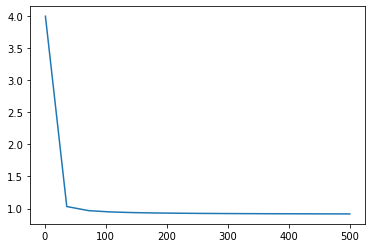

In [ ]:
plt.plot(space, profits)

In [ ]:
l = 15
k_min = 1
k_max = 150
steps = 15
space = np.linspace(k_min, k_max, steps, dtype=int)
profits_l = []
for i in space:
    print(i)
    profits_l.append(actualProfit(a,c,rho,i,l))

1
11
22
32
43
54
64
75
86


KeyboardInterrupt: 

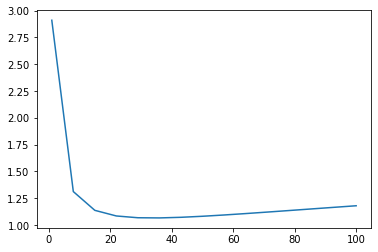

In [ ]:
plt.plot(space, profits_l)

## D Regular

In [353]:
l = 30 
d = 1
k = 9

def make_core_reg_periphery(l,d,k):
    core = nx.random_regular_graph(d, l)
    n = (1+k)*l
    mat = np.zeros((n,n))
    mat[0:l, 0:l] = nx.to_numpy_array(core)
    for i in range(l, n):
        parent = (i - l) // k
        mat[parent, i] = 1
    return mat 

def guess_core_f_reg(d, k):
    return Ratio([1,k], [1, -2*d, -k])

def guess_core_g_reg(d,k):
    return Ratio([1,1-2*d], [1, -2*d, -k])


In [354]:
m = make_core_reg_periphery(l,d,k)
n = len(m)
mat = m + m.T
v =  lin.inv( np.eye(n,n) - 0.02 * mat ) @ np.ones((n,1))
print(v[0,0], v[-1,0])
f = guess_core_f_reg(d, k)
g = guess_core_g_reg(d,k)
print(f.eval(0.02))
print(g.eval(0.02))


1.23379339188624 1.0246758678377248
1.23379339188624
1.0246758678377248


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

## Lose Experimennt
Here we consider a small case where we can enumerate all of the possible graphs with degree sequence
[3,2,2,2,1,1,1]. What can we say about various pricing strategies? 


### The graphs

In [338]:
# G1 = np.zeros((7,7))
# G2 = np.zeros((7,7))
# G3 = np.zeros((7,7))
# G4 = np.zeros((7,7))
# G1[0,1] = G1[1,2] = G1[2,0] = 1
# G1[3,4] = G1[3,5] = G1[3,6] = 1
# G2[0,1] = G2[0,2] =  1
# G2[3,4] = G2[4,5] = G2[5,3] = 1
# G2[3,6] = 1
# G3[0,1] = G3[0,2] = G3[0,3] = 1
# G3[1,4] = G3[2,5] = G3[3,6] = 1
# G4[0,1] = G4[0,2] = G4[0,3] = 1
# G4[3,4] = G4[4,5] = G4[5,6] = 1
# graphs = [G1, G2, G3, G4]
# G1 = np.zeros((8,8))
# G2 = np.zeros((8,8))
# G3 = np.zeros((8,8))
# G4 = np.zeros((8,8))
# G5 = np.zeros((8,8))
# G6 = np.zeros((8,8))
# G1[0,1] = G1[1,2] = G1[2,3] = G1[3,4] =G1[4,5] = G1[5,0] = 1
# G1[6,7] = 1
# G2[0,1] = G2[1,2] = G2[2,0] = 1
# G2[3,4] =G2[4,5] = G2[5,3] = 1
# G2[6,7] = 1
# G3[0,1] = G3[1,2] = G3[2,3] = G3[3,4] = G3[4,0] =  1
# G3[5,6] = G3[5,7] =1
# G4[0,1] = G4[1,2] = G4[2,3] = G4[3,0] = 1
# G4[4,5] = G4[4,6] = G4[6,7] = 1
# G5[0,1] = G5[1,2] = G5[2,0] = 1
# G5[3,4] = G5[4,5] = G5[5,6] = G5[6,7] = 1
# G6[0,1] = G6[1,2] = G6[2,3] = G6[3,4] = G6[4,5] = G6[5,6] = G6[6,7] = 1
G = nx.fast_gnp_random_graph(500, 1.3/500, directed=True)
in_deg = [d for v,d in G.in_degree()]
out_deg = [d for v,d in G.out_degree()]
graphs = [ nx.to_numpy_array( nx.directed_configuration_model(in_deg, out_deg)) for i in range(50)]



In [339]:
def centralty(A: np.matrix, rho: float) -> np.matrix:
    """

    Parameters
    ----------
    A : np matrix
    rho : network effect

    Returns
    -------
    Centrality vector as described in paper
    """
    n = A.shape[0]
    ident = np.eye(n, n)
    ones = np.ones((n, 1))
    ApA = A + A.T
    central = lin.inv(ident - (rho * ApA))
    central = central @ ones  
    return central

def price_vector(a, c, discount, G):
    n = len(G)
    rho = discount / specNorm(G + G.T)
    frac1 = (a+c)/2
    frac2 = rho * ( (a-c)/2)
    return (frac1 * np.ones((n,1))) + (frac2 * (G - G.T) @ centralty(G, rho))
    
def optProfit(G, discount, a, c):
    n = len(G)
    rho = discount / specNorm(G + G.T)
    price = price_vector(a, c, discount, G)
    consu = lin.inv(np.eye(n,n) - 2*rho*G)
    consu = 0.5 * consu @ (a * np.ones((n,1)) - price)
    profit = (price - c*np.ones((n,1))).T @ consu
    return profit[0,0]
 
def computerdProfift(G, v, discount, a, c):
    n = len(G)
    rho = discount / specNorm(G + G.T)
    price = v
    consu = lin.inv(np.eye(n,n) - 2*rho*G)
    consu = 0.5 * consu @ (a * np.ones((n,1)) - price)
    profit = (price - c*np.ones((n,1))).T @ consu
    return profit[0,0]


In [340]:
a = 5 
c = 4 
rho = 0.9
opt_profits = [optProfit(G, rho, a, c) for G in graphs]
actual_prices = [price_vector(a, c, rho, G) for G in graphs]

In [341]:
# get max_G Profit_G* - Profit_G(v)
def worst_gap(graphs, opts, v):
    profits = [computerdProfift(G, v, rho, a,c) for G in graphs]
    worst_score = -np.inf 
    worst_idx = -1
    for i in range(len(graphs)):
        s = opts[i] - profits[i]
        if (s < 0):
            print("???????")
        if(s > worst_score):
            worst_score = s 
            worst_idx = i 
    return worst_score


# def aveverge_G Profit-G* - Profit_G(v)
def average_gap(graphs, opts, v):
    profits = [computerdProfift(G, v, rho, a,c) for G in graphs]
    total = 0 
    for i in range(len(graphs)):
        s = opts[i] - profits[i] 
        total += opts[i] - profits[i]

    return total / len(graphs)


In [342]:
n = len(graphs[0])
vectors_min = np.zeros((n,1))
vectors_max = np.zeros((n,1))
for i in range(n):
    mn = np.inf 
    mx = -np.inf
    for j in range(len(graphs)):
        if(actual_prices[j][i] < mn):
            mn = actual_prices[j][i]
        if(actual_prices[j][i] > mx):
            mx = actual_prices[j][i]
    vectors_max[i] = mx
    vectors_min[i] = mn

In [346]:
n = 8
space = np.linspace(vectors_min, vectors_max, 20)
#np.random.shuffle(space)
mn = np.inf 
best_v = None
data = [] 
x = []
i = 0 
for v in space:
    print(i)
    i += 1
    ave_gap = worst_gap(graphs, opt_profits,v)
    if(ave_gap < 0):
        ## THis should never happen
        continue
    data.append(ave_gap)
    x.append(len(x)+1)
    if(ave_gap <= mn):
        mn = ave_gap
        best_v = v.copy()
print(mn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
228.4717852600099


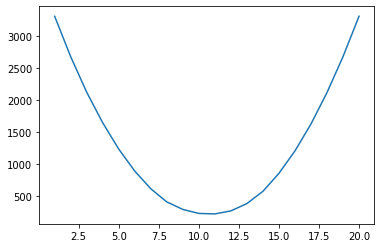

In [347]:
plt.plot(x, data)

In [42]:
v

array([[0.        , 0.        , 0.        ],
       [0.11111111, 0.22222222, 0.33333333],
       [0.22222222, 0.44444444, 0.66666667],
       [0.33333333, 0.66666667, 1.        ],
       [0.44444444, 0.88888889, 1.33333333],
       [0.55555556, 1.11111111, 1.66666667],
       [0.66666667, 1.33333333, 2.        ],
       [0.77777778, 1.55555556, 2.33333333],
       [0.88888889, 1.77777778, 2.66666667],
       [1.        , 2.        , 3.        ]])